# 今回の取り組み

- `clustering`でメモリを大量に消費しているので、原因を調べます

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
pip uninstall -qy DAJIN2
# pip install -q -e .
# pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

# 実験

In [57]:
from __future__ import annotations
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

#### * flox insertion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
    "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
    "examples/flox-cables2/AyabeTask1/design_cables2.fa",
    "single-ayabetask1",
    "mm10",
    True,
    14,
)



######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "clustering", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-ayabetask1...


In [4]:
import pickle
path_mut = "DAJINResults/.tempdir/single-ayabetask1/mutation_loci/barcode31.plk"
with open(path_mut, "rb") as f:
    MUTATION_LOCI_ALLELES = pickle.load(f)

In [5]:
classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
clust_sample = clustering.add_labels(
        classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS
    )
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

In [7]:
clust_sample[0]

{'QNAME': '002cbd51-86c7-4063-931b-12707594322c',
 'CSSPLIT': '=G,=G,=C,=A,=A,=G,=A,=A,=C,=G,=A,=C,=C,=T,=G,=C,=T,=T,=T,=T,=T,=A,=C,=C,=T,=T,=A,=C,=A,=G,=A,=A,=C,=C,=A,=A,=G,=C,=A,=T,=G,=C,=A,=T,=C,=T,-G,=G,=A,=T,=C,=A,=C,=C,=A,=A,=G,=A,=C,=A,=C,=A,=A,=A,=G,=G,=C,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=C,=C,=C,=A,=C,=T,=T,=C,=A,=T,=C,=A,=A,=G,=A,=A,=C,=A,=T,=G,=A,=G,=G,=C,=A,=G,=T,=A,=T,=G,=A,=C,=A,=C,=A,=A,=A,=G,=A,=A,=C,=A,=G,=C,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=G,=T,=A,=G,=G,=G,=C,=C,=A,=G,=G,=C,=C,=C,=G,=G,=G,=A,=A,=G,=G,=C,=C,=A,=C,=T,=G,=T,=G,=C,-T,=C,=C,=C,-T,=G,=T,=A,=C,=T,=G,=T,=A,=G,=G,=A,=T,=C,=A,=G,=G,=C,=C,=G,=T,=G,=T,=C,=T,=C,=T,-G,=G,=G,=G,=G,=C,=C,=A,=A,=A,=A,=A,=T,=A,=T,=G,=A,=G,=A,=C,=C,=C,=A,=G,=G,=C,=C,=C,=T,=G,=C,=C,*CT,=C,-T,=G,=T,=T,=G,=G,=C,=A,=G,=C,=A,=G,=C,=C,=C,=C,=T,=T,=C,=T,=C,=C,=A,=T,=C,=A,=C,=C,=C,=G,=T,=T,=G,=T,=C,=C,=C,=C,=T,=G,=A,-C,=C,=C,=T,=C,=T,=A,=T,=A,=T,=T,=G,=T,=T,=G,=A,=A,=C,=A,=C,=T,=G,=G,=C,*TC,=A,=G,=C,=A,=T,=A,=G,=C,=C,=A,=G,=G,=C,=C,=A,=G,=C,=A

In [8]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from typing import Generator
import json
from pathlib import Path
from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels

def read_json(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)

def _compress_insertion(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence,
    so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
    #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
    #TODO insertion配列をそのまま残す**必要がある。
    """
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        yield cssplit


def _extract_cssplits_in_mutation_by_3mer(
    cssplits: Generator[list[str]], mutation_loci: list[set[str]]
) -> list[list[str]]:
    cssplits_mutation = []
    for cssplit in cssplits:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = cssplit[i][0]  # +, - , *, =, N
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores

In [9]:
allele = "flox"
mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
knockin_loci = KNOCKIN_LOCI_ALLELES[allele]

cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele))
midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
mutation_score = make_score(
    cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
)
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)

- メモリプロファイルをします

In [46]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

from collections import defaultdict
from itertools import groupby
from typing import Generator
import json
from pathlib import Path
from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels

def read_json(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)

def _compress_insertion(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence,
    so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
    #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
    #TODO insertion配列をそのまま残す**必要がある。
    """
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        yield cssplit

def _extract_cssplits_in_mutation_by_3mer(cssplits, mutation_loci: list[set[str]]) -> list[list[str]]:
    cssplits_mutation = []
    for cssplit in cssplits:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = cssplit[i][0]  # +, - , *, =, N
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores


###############################################################################
# main
###############################################################################


def clustering(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    allele = "control"
    mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
    knockin_loci = set()
    if allele in KNOCKIN_LOCI_ALLELES:
        knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
    cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in classif_sample if cs["ALLELE"] == allele))
    midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
    cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
    cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
    cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
    mutation_score = make_score(
        cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
    )
    scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
    scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
    return scores_sample, scores_control

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess, classification
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)

    KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
    classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    _ = clustering(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


Overwriting tmp_memory_profile.py


In [47]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt
rm mprofile*

execute...

real	1m38.207s
user	1m29.193s
sys	0m5.776s


Using last profile data.
mprof: Sampling memory every 0.1s
running new process
running as a Python program...


- メモリは常に増加しています

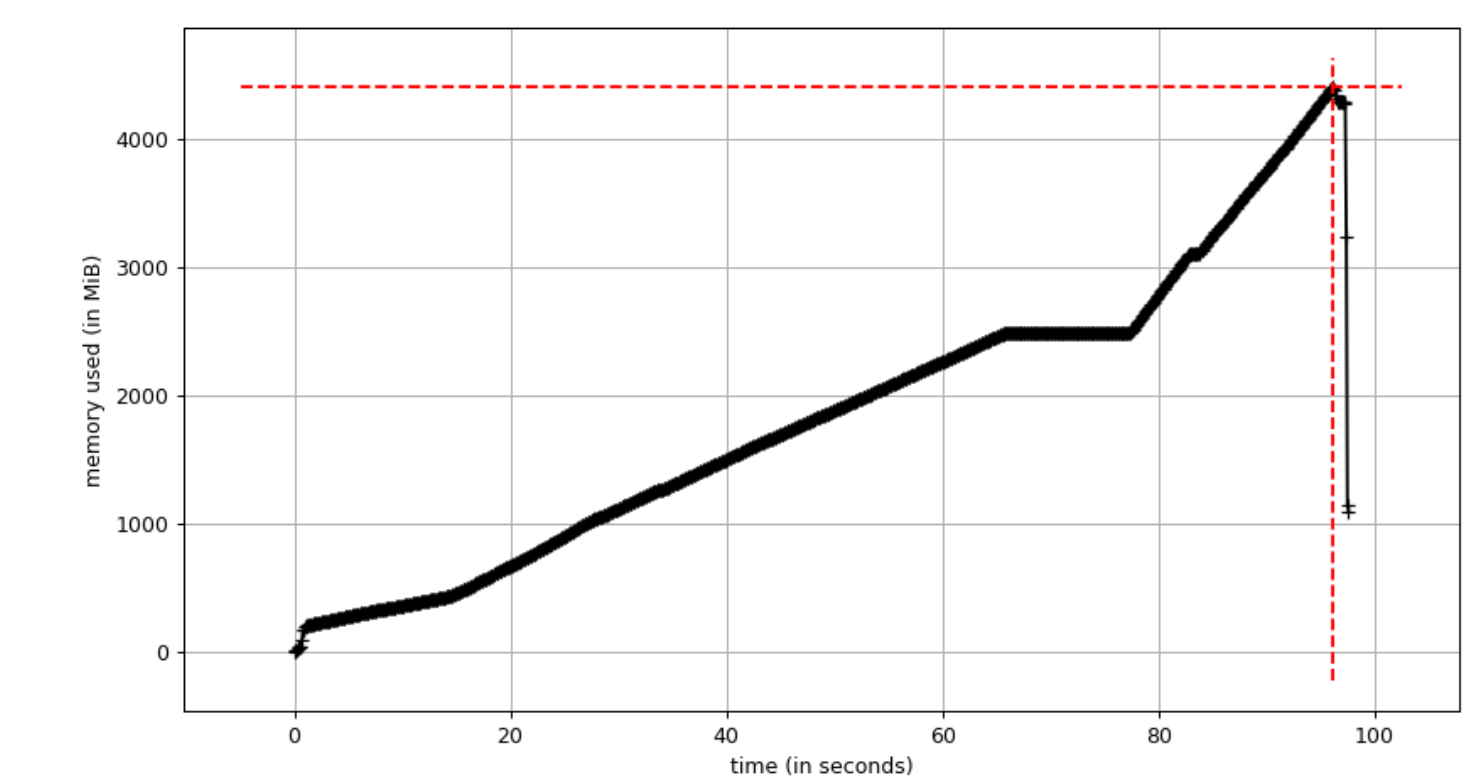

In [52]:
%%writefile tmp_memory_profile.py
from __future__ import annotations
from memory_profiler import profile

###########################################################################

from collections import defaultdict
from itertools import groupby
from typing import Generator
import json
from pathlib import Path
from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels


def read_json(filepath) -> list[dict[str, str]]:
    midsv_sample = []
    with open(filepath, "r") as f:
        for line in f:
            midsv_sample.append(json.loads(line))
    return midsv_sample

def _generate_mutation_kmers(midsv_sample: Generator[list[str]], mutation_loci: list[set[str]]) -> Generator[list[str]]:
    for cssplit in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = cssplit[i][0]  # +, - , *, =, N
            """Insertion will be subdivided by sequence error in the its sequence,
            so it is compressed as a '+I' to eliminate mutations.
            #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
            #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
            #TODO insertion配列をそのまま残す**必要がある。
            """
            if mutation == "+":
                cssplit[i] = "+I" + cssplit[i].split("|")[-1]
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        yield cs_mutation


def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores


###############################################################################
# main
###############################################################################

def clustering(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES) -> None:
    allele = "control"
    mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
    knockin_loci = set()
    midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
    cssplits_control = _generate_mutation_kmers(midsv_control, mutation_loci)
    return next(cssplits_control)

###############################################################################

if __name__ == "__main__":
    # 引数
    from DAJIN2.core import preprocess, classification
    from pathlib import Path
    import sys

    SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
        "misc/data/r10_barcode31.fq.gz",
        "misc/data/r10_barcode32.fq.gz",
        "misc/data/tyr_control.fasta",
        "single-r10",
        "mm10",
        True,
        30,
    )

    TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
    SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
    CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
    FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
    import pickle

    MUTATION_LOCI_ALLELES = pickle.load(open(f"DAJINResults/.tempdir/single-r10/mutation_loci/{SAMPLE_NAME}.plk", "rb"))
    print("execute...", file=sys.stderr)

    KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
    classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    _ = clustering(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES)


Overwriting tmp_memory_profile.py


In [53]:
%%bash
export PYTHONPATH=src
time mprof run tmp_memory_profile.py > tmp_memory_profile.txt
mprof plot -o tmp_image.png --backend agg
cat tmp_memory_profile.txt

execute...

real	0m13.297s
user	0m10.953s
sys	0m3.959s


Using last profile data.
mprof: Sampling memory every 0.1s
running new process
running as a Python program...


- やはりリストで持つとメモリを相当消費します

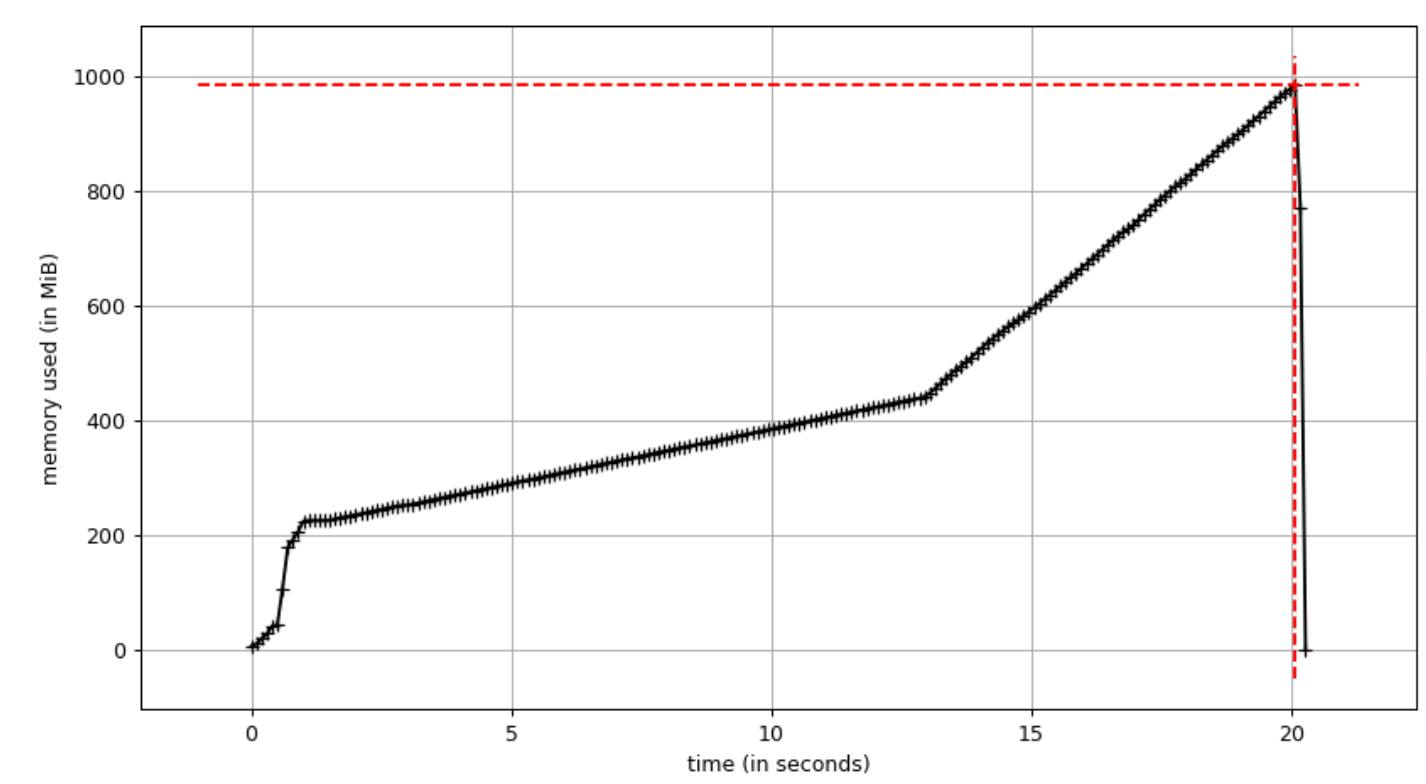

- オブジェクトの再利用をしない（Generatorですべて済ます）のが理想ですが、どうも思いつきません…
- そのため、まずはひとつひとつのオブジェクトをファイルに保存する方法での解決を目指します

In [55]:

def _generate_mutation_kmers(midsv_sample: Generator[list[str]], mutation_loci: list[set[str]]) -> Generator[list[str]]:
    for cssplit in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = cssplit[i][0]  # +, - , *, =, N
            """Insertion will be subdivided by sequence error in the its sequence,
            so it is compressed as a '+I' to eliminate mutations.
            #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
            #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
            #TODO insertion配列をそのまま残す**必要がある。
            """
            if mutation == "+":
                cssplit[i] = "+I" + cssplit[i].split("|")[-1]
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        yield cs_mutation

midsv_sample = (cs for cs in classif_sample if cs["ALLELE"] == allele)
x = _generate_mutation_kmers(midsv_sample, mutation_loci)

In [58]:
print(next(x))
import json
def save_as_json(filepath: Path | str, data: Generator) -> None:
    with open(filepath, "w") as f:
        for line in data:
            f.write(json.dumps(line) + "\n")

['N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 

In [59]:
save_as_json("tmp.json", x)
y = read_json("tmp.json")
print(next(y))

In [64]:
x = []
for i, xx in enumerate(range(1000)):
    x.append(xx)
    if i == 99:
        break
print(len(x))

100


- 中間ファイルを`.tempdir/{name}/clustering`内に保存するようにしました
- 動作確認をします

In [67]:
def read_json(filepath: Path | str) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def write_json(filepath: Path | str, data: Generator) -> None:
    with open(filepath, "w") as f:
        for line in data:
            f.write(json.dumps(line) + "\n")

allele  = "control"
mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]

if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
else:
    knockin_loci = set()

path_sample = Path(TEMPDIR, "clustering", f"{SAMPLE_NAME}_{allele}.json")
path_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
write_json(path_sample, (m for m in classif_sample if m["ALLELE"] == allele))
mutation_score = make_score(
    _generate_mutation_kmers(read_json(path_sample), mutation_loci),
    _generate_mutation_kmers(read_json(path_control), mutation_loci),
    mutation_loci,
    knockin_loci,
)
path_score_sample = Path(TEMPDIR, "clustering", f"{SAMPLE_NAME}_{allele}_score.json")
path_score_control = Path(TEMPDIR, "clustering", f"{CONTROL_NAME}_{allele}_score.json")
scores_sample = _annotate_score(_generate_mutation_kmers(read_json(path_sample), mutation_loci), mutation_score)
scores_control = _annotate_score(
    _generate_mutation_kmers(read_json(path_control), mutation_loci), mutation_score
)
write_json(path_score_sample, scores_sample)
write_json(path_score_control, scores_control)

In [68]:
labels = return_labels(path_score_sample, path_score_control)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/kuno/miniconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10376/3963363072.py", line 1, in <cell line: 1>
    labels = return_labels(path_score_sample, path_score_control)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/return_labels.py", line 56, in return_labels
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/return_labels.py", line 23, in reduce_dimension
TypeError: can only concatenate list (not "PosixPath") to list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kuno/miniconda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 1992, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/kuno/miniconda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_

In [87]:
from __future__ import annotations

import warnings
from collections import Counter
from typing import Generator
from pathlib import Path
import json
from itertools import chain

import numpy as np
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.mixture import GaussianMixture

from DAJIN2.core.clustering.merge_clusters import merge_clusters

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

###############################################################################
# Dimension reduction
###############################################################################


def reduce_dimension(scores_sample: Generator[list], scores_control: Generator[list]) -> np.array:
    scores = list(chain(scores_sample, scores_control))
    pca = PCA(n_components=20).fit(scores)
    return pca.transform(scores)


def optimize_labels(X: np.array, coverage_sample, coverage_control) -> list[int]:
    n_components = min(20, coverage_sample + coverage_control)
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[:coverage_sample]
        labels_control = labels[coverage_sample:]
        labels_merged = merge_clusters(labels_control, labels_sample)
        # Reads < 1% in the control are considered clustering errors and are not counted
        count_control = Counter(labels_control)
        num_labels_control = sum(1 for reads in count_control.values() if reads / sum(count_control.values()) * 100 > 1)
        if num_labels_control > 1:
            labels_results = [1] * len(labels_merged)
        else:
            labels_results = labels_merged
    return labels_results


def read_json(filepath: Path | str) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def count_newlines(filepath: Path | str) -> int:
    def _make_gen(reader):
        while True:
            b = reader(2**16)
            if not b:
                break
            yield b

    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count


###############################################################################
# main
###############################################################################


def return_labels(path_scores_sample: Path | str, path_scores_control: Path | str) -> list[int]:
    np.random.seed(seed=1)
    coverage_sample = count_newlines(path_scores_sample)
    coverage_control = count_newlines(path_scores_control)
    # Remove abnormal minor reads from control
    X_control = reduce_dimension([], read_json(path_scores_control))
    labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
    label_most = Counter(labels).most_common()[0][0]
    # Subset control to 1000 reads
    scores_control_subset = []
    for i, (label, score) in enumerate(zip(labels, read_json(path_scores_control))):
        if label == label_most:
            scores_control_subset.append(score)
        if i == 999:
            break
    X = reduce_dimension(read_json(path_scores_sample), scores_control_subset)
    labels = optimize_labels(X, coverage_sample, coverage_control)
    return labels



In [88]:
labels = return_labels(path_score_sample, path_score_control)

In [89]:
Counter(labels)

Counter({1: 428})

- stx2の3アレルで検証します

In [90]:
from __future__ import annotations
from pathlib import Path

from DAJIN2.core import preprocess, classification, clustering, consensus, report

##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion",
    "mm10",
    True,
    30,
)



######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "clustering", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-stx2deletion...


In [91]:
import pickle
path_mut = f"{TEMPDIR}/mutation_loci/{SAMPLE_NAME}.plk"
with open(path_mut, "rb") as f:
    MUTATION_LOCI_ALLELES = pickle.load(f)
classif_sample = classification.classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)

In [95]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from typing import Generator
import json
from pathlib import Path
from DAJIN2.core.clustering.make_score import make_score

import warnings
from collections import Counter
from typing import Generator
from pathlib import Path
import json
from itertools import chain

import numpy as np
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.mixture import GaussianMixture

from DAJIN2.core.clustering.merge_clusters import merge_clusters

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

###############################################################################
# Dimension reduction
###############################################################################


def reduce_dimension(scores_sample: Generator[list], scores_control: Generator[list]) -> np.array:
    scores = list(chain(scores_sample, scores_control))
    pca = PCA(n_components=20).fit(scores)
    return pca.transform(scores)


def optimize_labels(X: np.array, coverage_sample, coverage_control) -> list[int]:
    n_components = min(20, coverage_sample + coverage_control)
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[:coverage_sample]
        labels_control = labels[coverage_sample:]
        labels_merged = merge_clusters(labels_control, labels_sample)
        # Reads < 1% in the control are considered clustering errors and are not counted
        count_control = Counter(labels_control)
        num_labels_control = sum(1 for reads in count_control.values() if reads / sum(count_control.values()) * 100 > 1)
        if num_labels_control > 1:
            labels_results = [1] * len(labels_merged)
        else:
            labels_results = labels_merged
    return labels_results


def read_json(filepath: Path | str) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def count_newlines(filepath: Path | str) -> int:
    def _make_gen(reader):
        while True:
            b = reader(2**16)
            if not b:
                break
            yield b

    with open(filepath, "rb") as f:
        count = sum(buf.count(b"\n") for buf in _make_gen(f.raw.read))
    return count


###############################################################################
# main
###############################################################################


def return_labels(path_score_sample: Path | str, path_score_control: Path | str) -> list[int]:
    np.random.seed(seed=1)
    coverage_sample = count_newlines(path_score_sample)
    coverage_control = count_newlines(path_score_control)
    # Remove abnormal minor reads from control
    X_control = reduce_dimension([], read_json(path_score_control))
    labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
    label_most = Counter(labels).most_common()[0][0]
    # Subset control to 1000 reads
    scores_control_subset = []
    for i, (label, score) in enumerate(zip(labels, read_json(path_score_control))):
        if label == label_most:
            scores_control_subset.append(score)
        if i == 999:
            break
    X = reduce_dimension(read_json(path_score_sample), scores_control_subset)
    labels = optimize_labels(X, coverage_sample, coverage_control)
    return labels

# def _compress_insertion(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
#     """Insertion will be subdivided by sequence error in the its sequence,
#     so it is compressed as a '+I' to eliminate mutations.
#     #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
#     #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
#     #TODO insertion配列をそのまま残す**必要がある。
#     """
#     for cssplit in cssplits:
#         for i, cs in enumerate(cssplit):
#             if cs.startswith("+"):
#                 cssplit[i] = "+I" + cs.split("|")[-1]
#         yield cssplit


def _generate_mutation_kmers(midsv_sample: Generator[list[str]], mutation_loci: list[set[str]]) -> Generator[list[str]]:
    for cssplit in (cs["CSSPLIT"].split(",") for cs in midsv_sample):
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = cssplit[i][0]  # +, - , *, =, N
            """Insertion will be subdivided by sequence error in the its sequence,
            so it is compressed as a '+I' to eliminate mutations.
            #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
            #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
            #TODO insertion配列をそのまま残す**必要がある。
            """
            if mutation == "+":
                cssplit[i] = "+I" + cssplit[i].split("|")[-1]
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        yield cs_mutation


def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> Generator[list[float]]:
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        yield score


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def read_json(filepath: Path | str) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def write_json(filepath: Path | str, data: Generator) -> None:
    with open(filepath, "w") as f:
        for line in data:
            f.write(json.dumps(line) + "\n")


def add_labels(
    classif_sample, TEMPDIR, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS: int = 1
) -> list[dict[str]]:
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
        if all(m == set() for m in mutation_loci):
            labels = [1] * len(classif_sample)
            labels_reorder = _reorder_labels(labels, start=max_label)
            max_label = max(labels_reorder)
            labels_all.extend(labels_reorder)
            continue
        if allele in KNOCKIN_LOCI_ALLELES:
            knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
        else:
            knockin_loci = set()
        path_sample = Path(TEMPDIR, "clustering", f"{SAMPLE_NAME}_{allele}.json")
        path_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
        write_json(path_sample, group)
        mutation_score = make_score(
            _generate_mutation_kmers(read_json(path_sample), mutation_loci),
            _generate_mutation_kmers(read_json(path_control), mutation_loci),
            mutation_loci,
            knockin_loci,
        )
        path_score_sample = Path(TEMPDIR, "clustering", f"{SAMPLE_NAME}_{allele}_score.json")
        path_score_control = Path(TEMPDIR, "clustering", f"{CONTROL_NAME}_{allele}_score.json")
        scores_sample = _annotate_score(_generate_mutation_kmers(read_json(path_sample), mutation_loci), mutation_score)
        write_json(path_score_sample, scores_sample)
        scores_control = _annotate_score(
            _generate_mutation_kmers(read_json(path_control), mutation_loci), mutation_score
        )
        write_json(path_score_control, scores_control)
        labels = return_labels(path_score_sample, path_score_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample

In [96]:
clust_sample = add_labels(
        classif_sample, TEMPDIR, SAMPLE_NAME, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS
    )
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)

In [97]:
from collections import defaultdict
count_label = defaultdict(int)
for samp in clust_sample:
    count_label[samp["LABEL"]] += 1

print(count_label)

defaultdict(<class 'int'>, {1: 1497, 2: 3})


- なぜかクラスタリングがうまく行かなくなりました…

In [98]:
allele = "deletion"
mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]

if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
else:
    knockin_loci = set()

group = (m for m in classif_sample if m["ALLELE"] == allele)
path_sample = Path(TEMPDIR, "clustering", f"{SAMPLE_NAME}_{allele}.json")
path_control = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json")
write_json(path_sample, group)

mutation_score = make_score(
    _generate_mutation_kmers(read_json(path_sample), mutation_loci),
    _generate_mutation_kmers(read_json(path_control), mutation_loci),
    mutation_loci,
    knockin_loci,
)
path_score_sample = Path(TEMPDIR, "clustering", f"{SAMPLE_NAME}_{allele}_score.json")
path_score_control = Path(TEMPDIR, "clustering", f"{CONTROL_NAME}_{allele}_score.json")
scores_sample = _annotate_score(_generate_mutation_kmers(read_json(path_sample), mutation_loci), mutation_score)
write_json(path_score_sample, scores_sample)
scores_control = _annotate_score(
    _generate_mutation_kmers(read_json(path_control), mutation_loci), mutation_score
)
write_json(path_score_control, scores_control)

labels = return_labels(path_score_sample, path_score_control)

In [99]:
print(Counter(labels))

Counter({1: 1497})


In [100]:
score_sample = list(read_json(path_score_sample))
score_control = list(read_json(path_score_control))

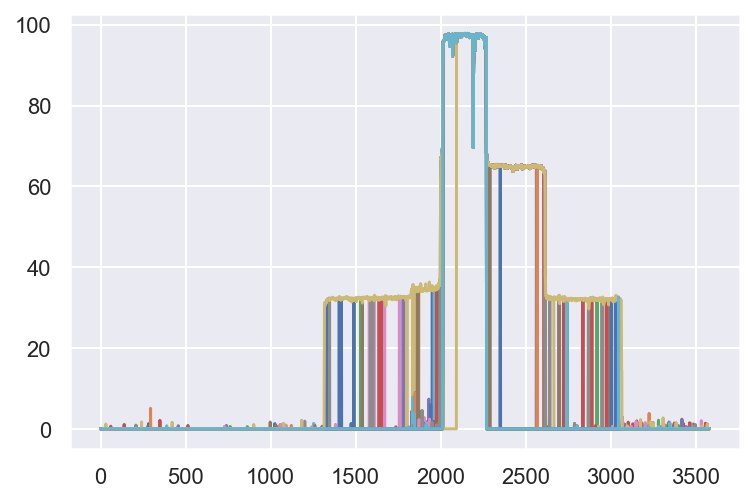

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

for i in range(20):
    plt.plot(score_sample[i])


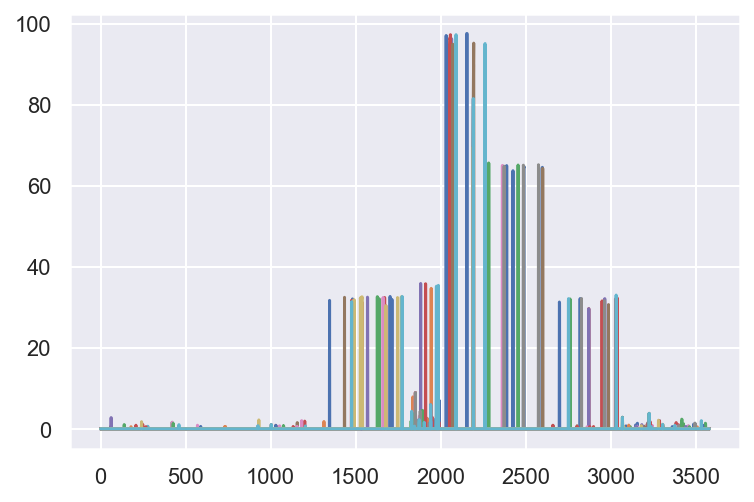

In [109]:
for i in range(20):
    plt.plot(score_control[i])

- とくにスコアリングには問題なさそうです

In [119]:
np.random.seed(seed=1)
coverage_sample = count_newlines(path_score_sample)
coverage_control = count_newlines(path_score_control)
# Remove abnormal minor reads from control
X_control = reduce_dimension([], read_json(path_score_control))
labels = GaussianMixture(n_components=2, random_state=1).fit_predict(X_control)
label_most = Counter(labels).most_common()[0][0]
scores_control_subset = []
count = 0
for label, score in zip(labels, read_json(path_score_control)):
    if label == label_most:
        scores_control_subset.append(score)
        count += 1
    if count == 1000:
        break

In [120]:
print(len(scores_control_subset))

1000


In [121]:
X = reduce_dimension(read_json(path_score_sample), scores_control_subset)
labels = optimize_labels(X, coverage_sample, coverage_control)
print(Counter(labels))

Counter({1: 1497})


In [136]:
def optimize_labels(X: np.array, coverage_sample, coverage_control) -> list[int]:
    n_components = min(20, coverage_sample + coverage_control)
    for i in range(1, n_components):
        np.random.seed(seed=1)
        labels = GaussianMixture(n_components=i, random_state=1).fit_predict(X)
        labels = labels.tolist()
        labels_sample = labels[:coverage_sample]
        labels_control = labels[coverage_sample:]
        labels_merged = merge_clusters(labels_control, labels_sample)
        print(i, Counter(labels_sample), Counter(labels_control), Counter(labels_merged))
        # Reads < 1% in the control are considered clustering errors and are not counted
        count_control = Counter(labels_control)
        num_labels_control = sum(1 for reads in count_control.values() if reads / sum(count_control.values()) * 100 > 1)
        if num_labels_control > 1:
            return labels_merged
        else:
            labels_results = labels_merged
    return labels_results


In [137]:
labels = optimize_labels(X, coverage_sample, coverage_control)
print(Counter(labels))

1 Counter({0: 1497}) Counter({0: 1000}) Counter({1: 1497})
2 Counter({0: 1488, 1: 9}) Counter({1: 1000}) Counter({0: 1488, 2: 9})
3 Counter({2: 995, 0: 493, 1: 9}) Counter({1: 1000}) Counter({2: 995, 0: 493, 3: 9})
4 Counter({3: 498, 2: 497, 0: 493, 1: 9}) Counter({1: 1000}) Counter({3: 498, 2: 497, 0: 493, 4: 9})
5 Counter({3: 498, 2: 497, 0: 467, 4: 26, 1: 9}) Counter({1: 1000}) Counter({3: 498, 2: 497, 0: 467, 4: 26, 5: 9})
6 Counter({3: 498, 2: 497, 0: 467, 4: 26, 1: 7, 5: 2}) Counter({1: 997, 5: 3}) Counter({3: 507, 2: 497, 0: 467, 4: 26})
7 Counter({3: 498, 2: 497, 0: 440, 6: 27, 4: 26, 1: 7, 5: 2}) Counter({1: 997, 5: 3}) Counter({3: 507, 2: 497, 0: 440, 6: 27, 4: 26})
8 Counter({2: 497, 3: 495, 0: 463, 5: 27, 1: 7, 4: 4, 6: 2, 7: 2}) Counter({1: 988, 6: 12}) Counter({2: 503, 3: 495, 0: 463, 5: 27, 8: 9})
Counter({2: 503, 3: 495, 0: 463, 5: 27, 8: 9})


In [143]:
coverage_control = len(scores_control_subset)
print(coverage_control)
print(count_control)

1000
Counter({1: 988, 6: 12})


In [146]:
%%bash
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

pip uninstall -qy DAJIN2
pip install -q -U pip
pip install -q -e .
# pipの更新
# pip install -q -U -r requirements.txt

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
    sys.exit(load_entry_point('DAJIN2', 'console_scripts', 'DAJIN2')())
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 276, in main
    _execute_single_mode(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 41, in _execute_single_mode
    core_execute.execute_control(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 77, in execute_control
    _, CONTROL_NAME, FASTA_ALLELES, TEMPDIR, GENOME_COODINATES, CHROME_SIZE, THREADS = _format_inputs(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 59, in _format_inputs
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/preprocess/format_inputs.py", line 115, in cache_coodinates_and_chromsize
    Path(TEMPDIR, "cache", "genome_symbol.txt").write_text(GENO

tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-05-30 12:38:18: Preprocess test_barcode30...
2023-05-30 12:38:18: Mapping test_barcode30...
2023-05-30 12:38:28: Call MIDSV test_barcode30...
tests/data/knockout/test_barcode30.fq.gz is finished!
tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-05-30 12:38:36: Preprocess test_barcode25...
2023-05-30 12:39:18: Classify test_barcode25...
2023-05-30 12:39:21: Clustering test_barcode25...
2023-05-30 12:39:35: Consensus calling test_barcode25......
tests/data/knockout/test_barcode25.fq.gz is finished...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	1m32.439s
user	1m11.293s
sys	0m1.913s


- クラスタリングもうまくいきました

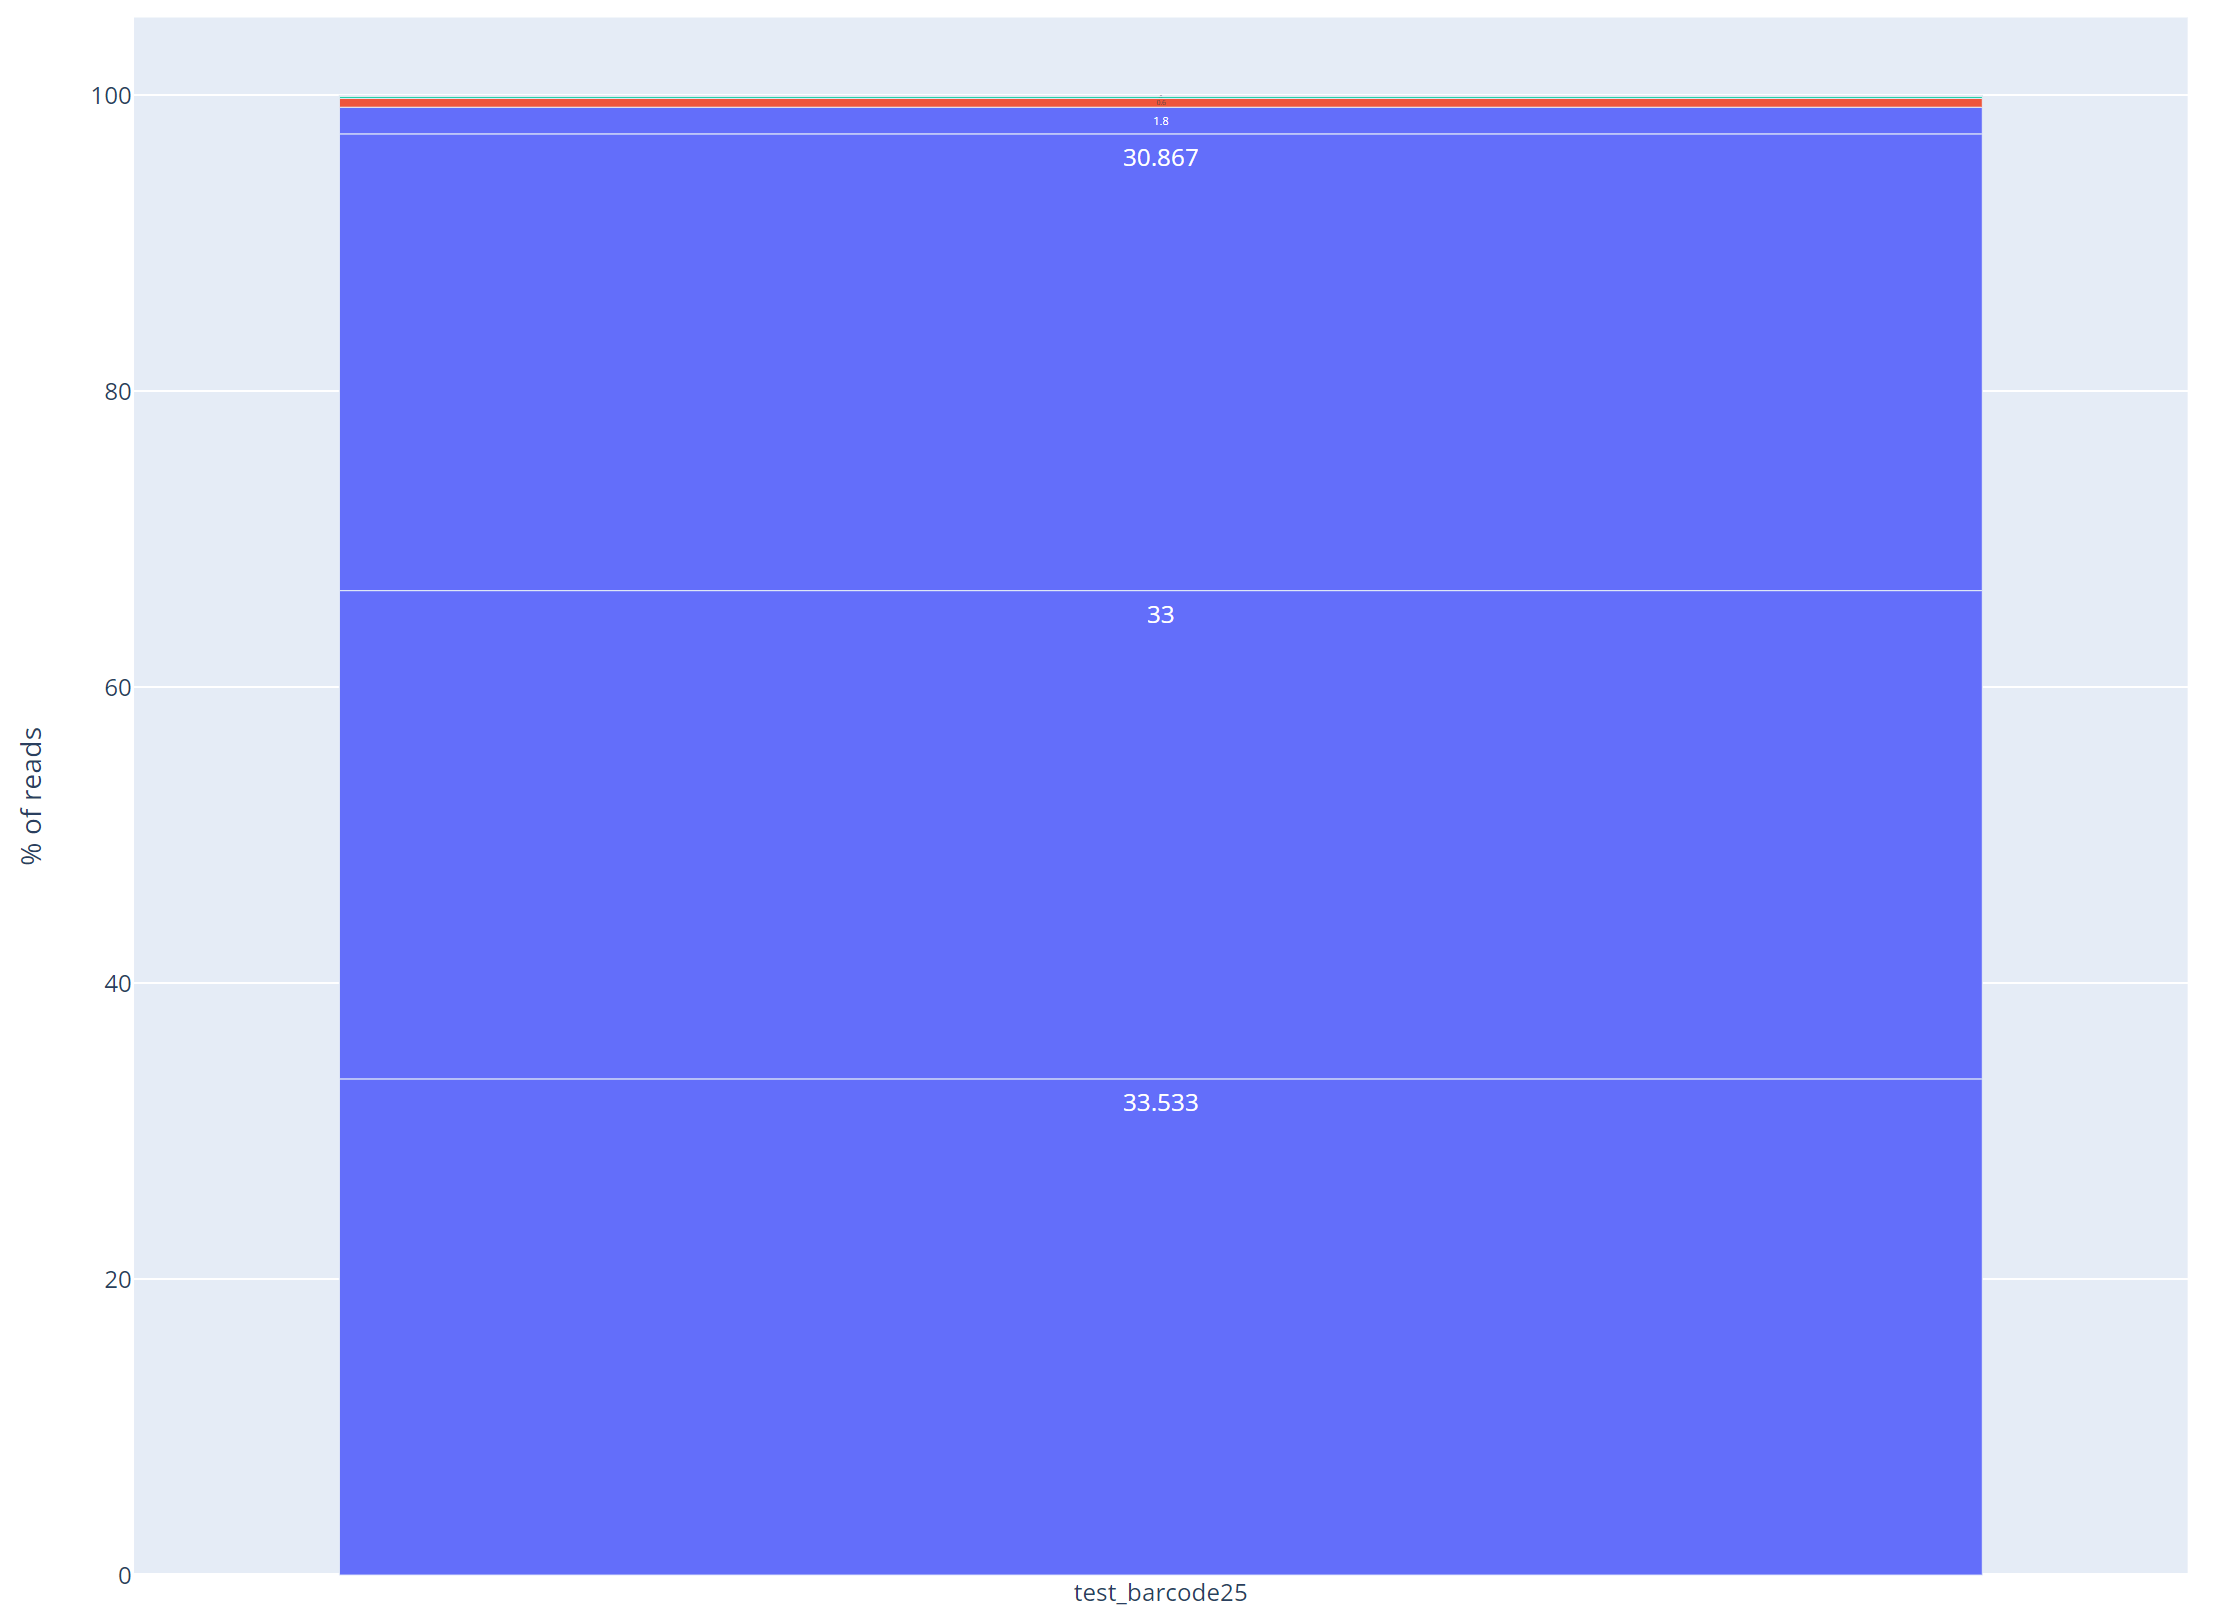


- R10のサンプルでエラーが起きました

- ✅マルチプロセスで動かすと、barcode05_targetのスコアが出力されませんでした
  - シングルプロセスだと問題なく作られました
  - -> これについては`clustering`で生成されるファイルの末尾にランダムな番号を付与することで対応しました

- シングルプロセスの`barcode05`について、挿入があるのにconsensusに反映されていないバグが有りました
  - そもそも挿入と欠失のアレルがうまくクラスタリングできていないようです

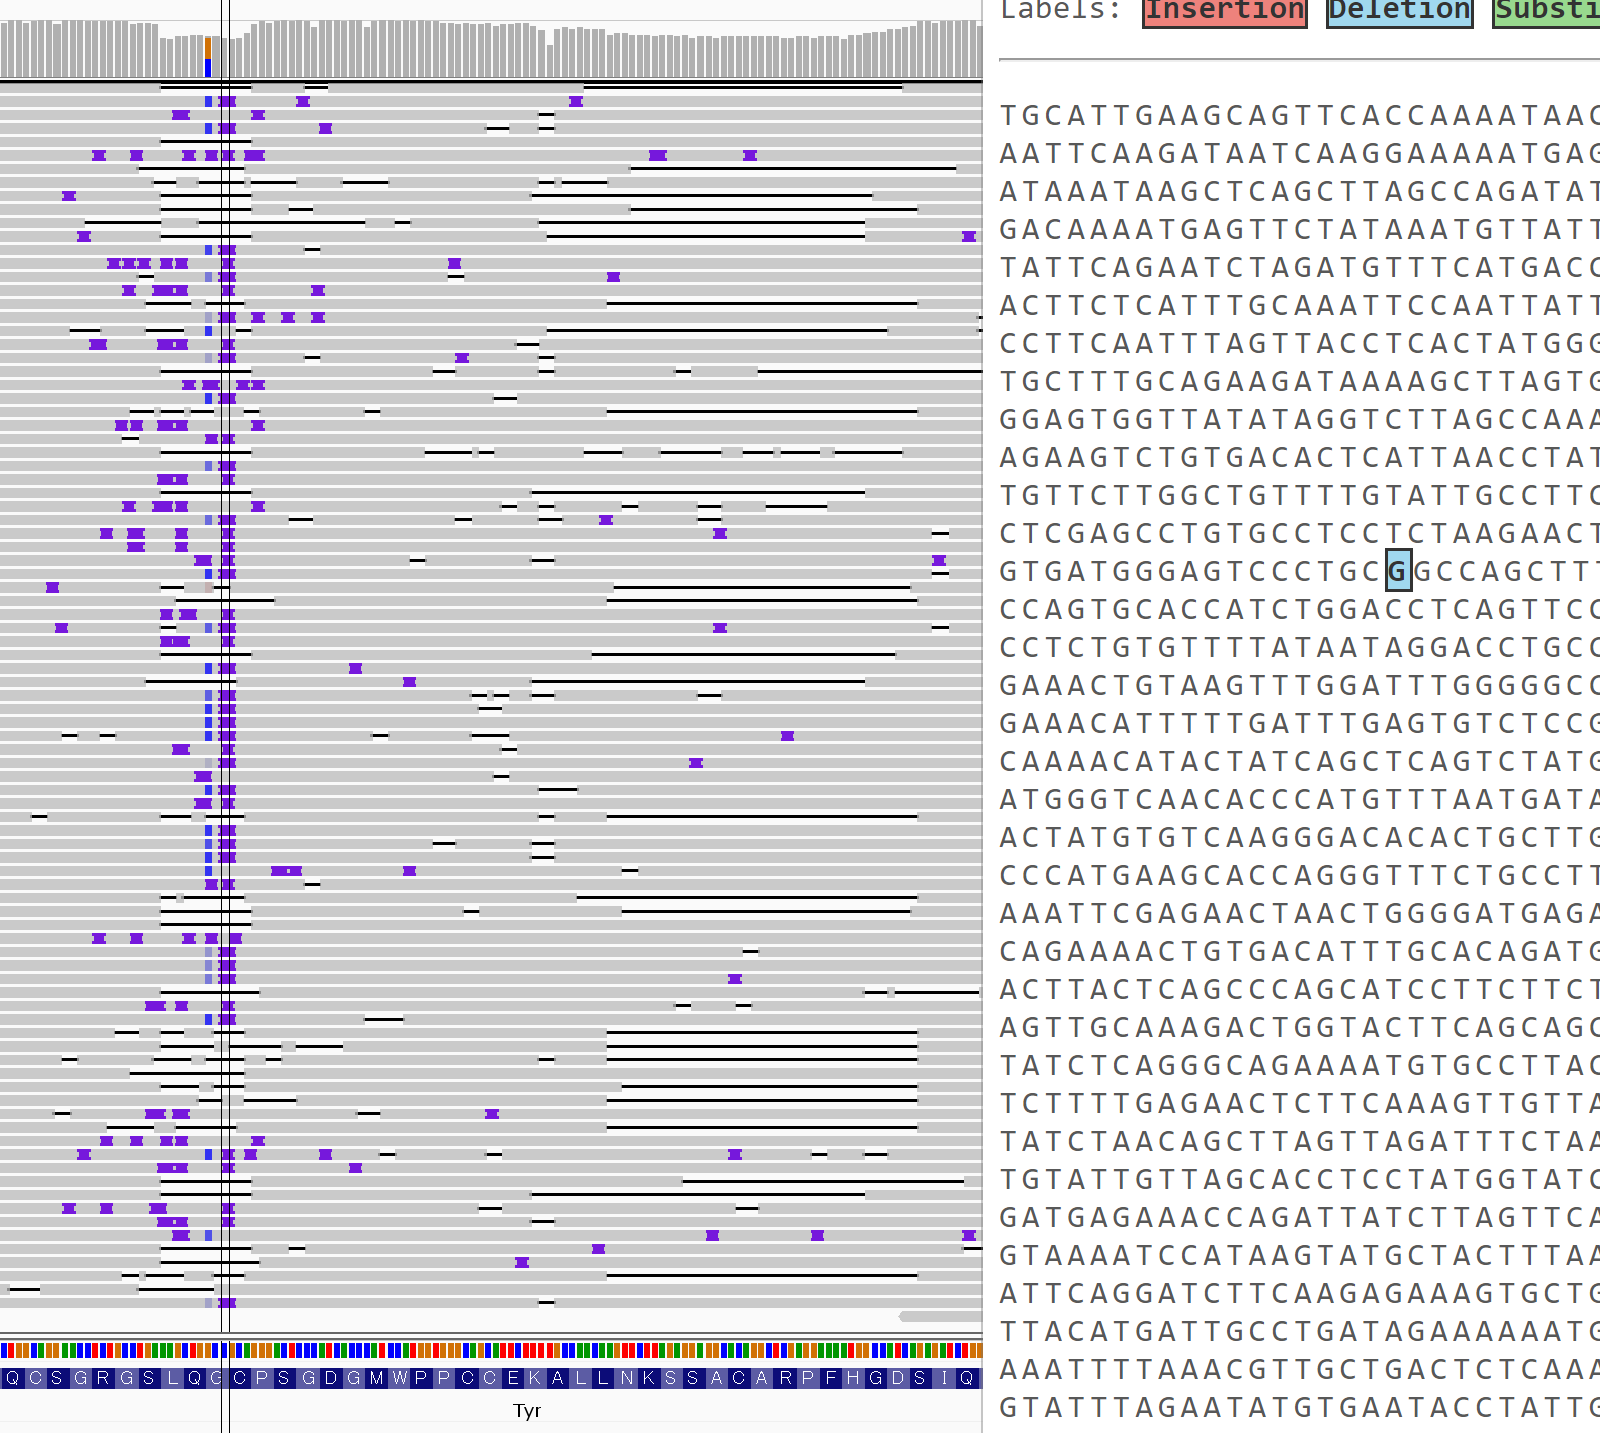

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `clustering`のメモリ消費量を減らすために、ファイルへのステップでmutation_lociを再度考慮するようにコードを改めました
  - メモリ消費量を減らすことができ、マルチプロセスに対する不安が少なくなりました

# 次に取り組むこと

⬜ R10の`barcode05`のように、アレルのクラスタリングのパフォーマンスが良くないサンプルがあるので対応します
    - `R10`の`barcode01`や`barcode02`において、targetアレルの分類性能が悪いようです
        - target intact（点変異）アレルに点変異のないアレルが半分ほどあります
        - `classification`を見直します

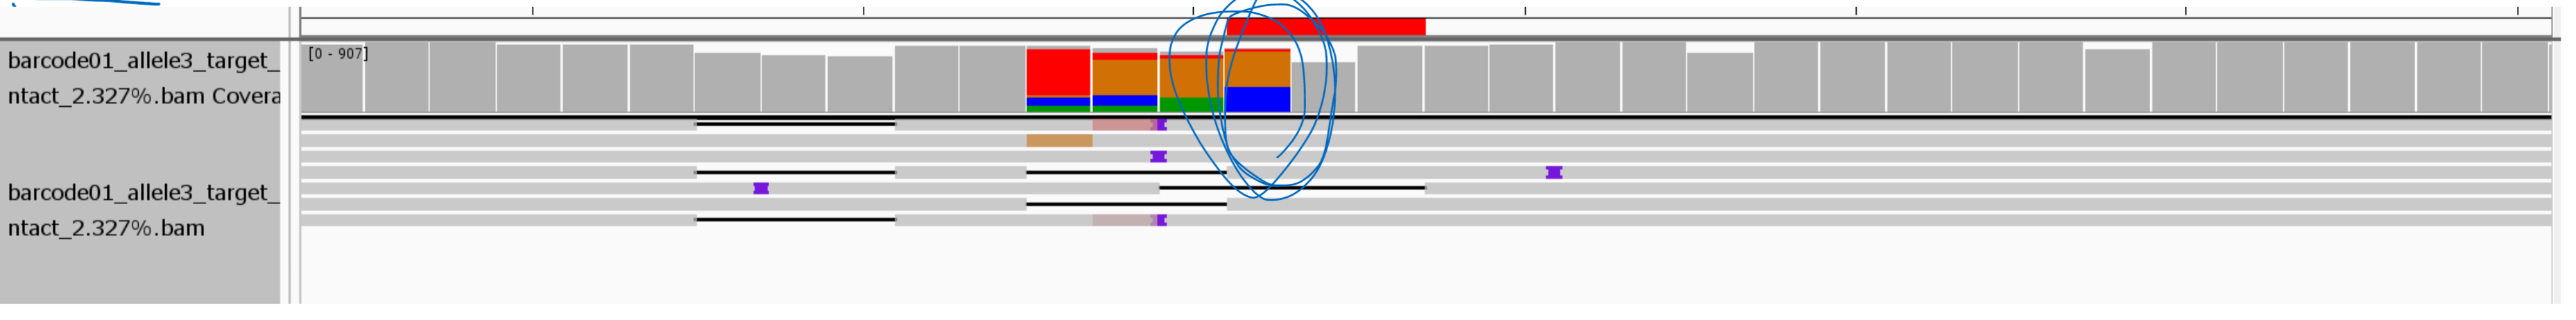

⬜ `R10`の`barcode05`においてもクラスタリングのパフォーマンスが悪いところが見受けられました
    - コンセンサス配列にも反映されていませんでした


⬜ `R10`において、アルビノのサンプル(`barcode31`)でも非常に細かくクラスタリングされてしまいました
- **まずは`barcode31`のクラスタリングを見直します**

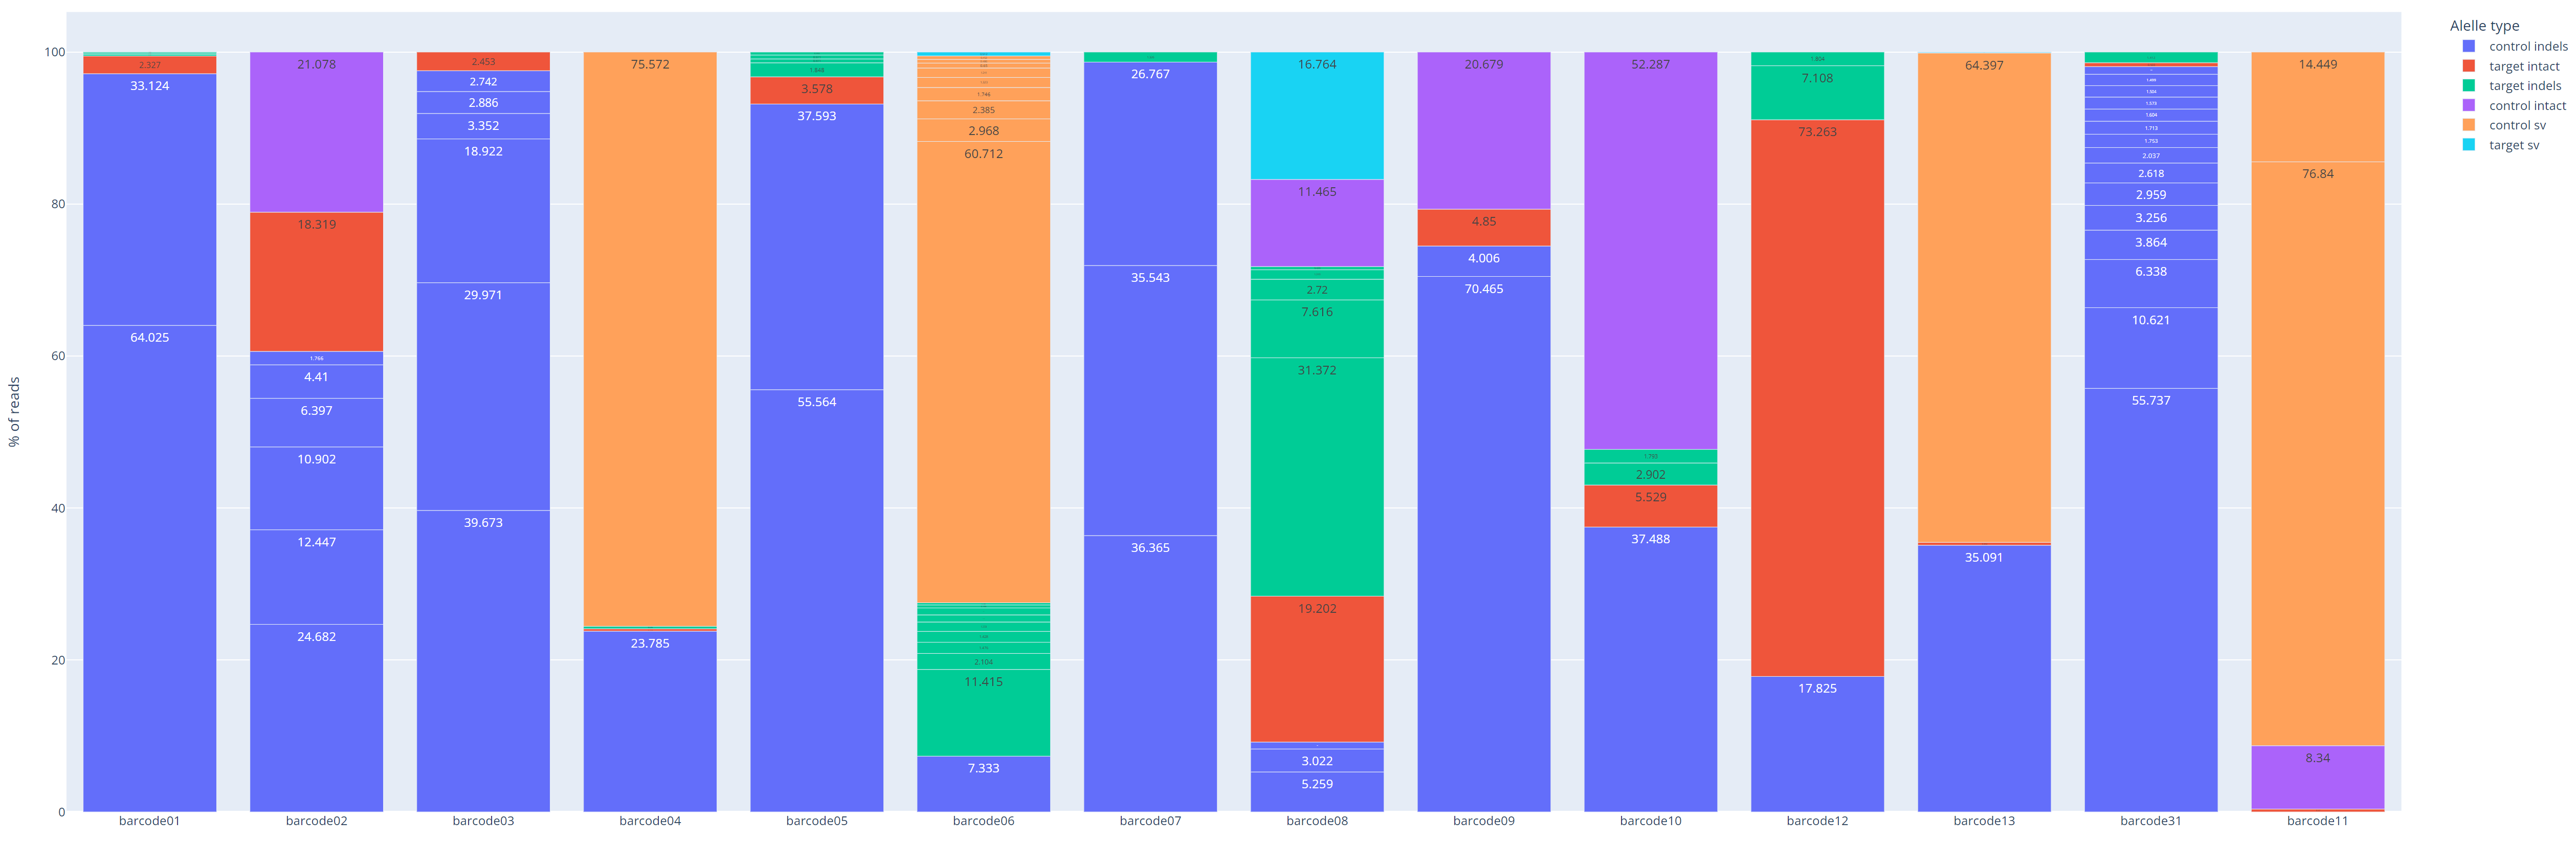



### Lists

+ ⬜ clusteringの性能がいまいち
+ ⬜ 棒グラフの並び順をソートする
+ ⬜ GUIの見栄え
+ ⬜ igv.jsの起動
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
